# 논문 작성을 위한 추가 실험
# 훈련 그래프를 보고 모델의 최적 상태에 대한 고민

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import albumentations
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


In [2]:
# Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용
# imgaug의 Sometimes()와 유사한 기능
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

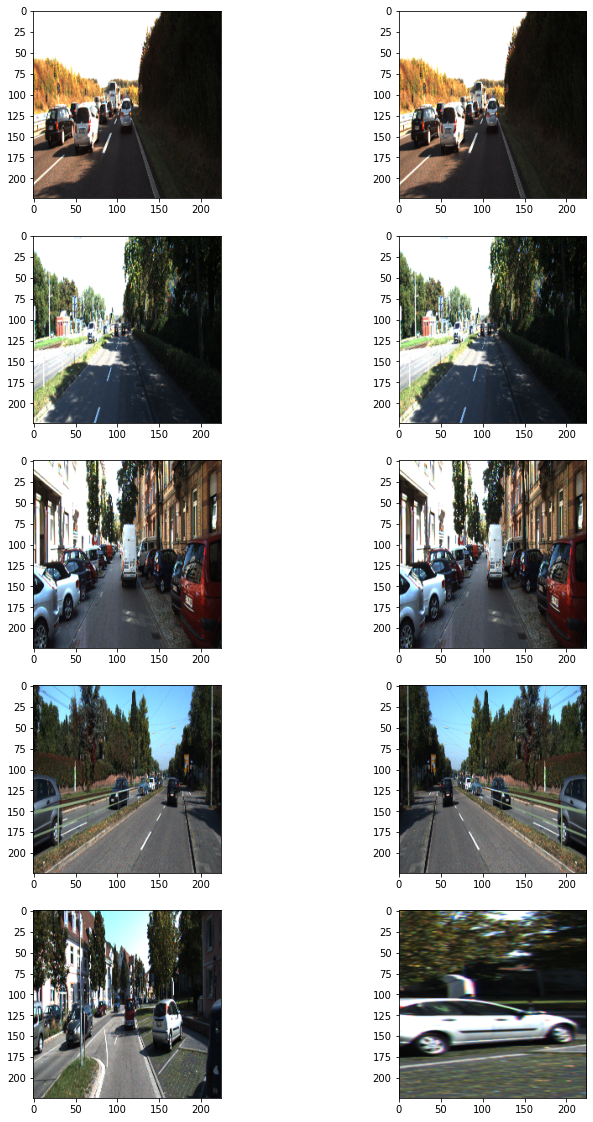

In [3]:
# augmentation 적용 및 확인
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
import random

# 데이터셋 train, val, test 분리
# tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               is_test=False,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.is_test = is_test
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.

        # 1. 전체 경로 불러오기
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))

        # 2. 정렬
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)

        # 3. 이미지와 라벨 쌍 만들기
        data = [ _ for _ in zip(input_images, label_images)]

        # 4. 셔플 - 단, 고정되도록 seed를 설정
        random.seed(980417)  # 항상 동일하게 셔플되도록 고정
        random.shuffle(data)

        # 5. 데이터 분할
        test_set = data[-16:]
        val_set = data[-32:-16]
        train_set = data[:-32]

        if self.is_test:
            return test_set
        elif self.is_train:
            return train_set
        else:
            return val_set
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
    return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    is_train=True
)

val_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_test=True
)

In [6]:
# 중복 데이터 검사
# 각 generator에서 이미지 경로 리스트 추출
train_paths = set([img for img, _ in train_generator.data])
val_paths = set([img for img, _ in val_generator.data])
test_paths = set([img for img, _ in test_generator.data])

# 교집합 확인
train_val_overlap = train_paths.intersection(val_paths)
train_test_overlap = train_paths.intersection(test_paths)
val_test_overlap = val_paths.intersection(test_paths)

# 결과 출력
print(f"Train-Val 중복 이미지 수: {len(train_val_overlap)}")
print(f"Train-Test 중복 이미지 수: {len(train_test_overlap)}")
print(f"Val-Test 중복 이미지 수: {len(val_test_overlap)}")

# 중복된 샘플이 있다면 출력해보기
if train_val_overlap:
    print("Train-Val 중복 예시:", list(train_val_overlap)[:5])
if train_test_overlap:
    print("Train-Test 중복 예시:", list(train_test_overlap)[:5])
if val_test_overlap:
    print("Val-Test 중복 예시:", list(val_test_overlap)[:5])


Train-Val 중복 이미지 수: 0
Train-Test 중복 이미지 수: 0
Val-Test 중복 이미지 수: 0


# U-net 구현 및 훈련

In [7]:
# U-Net 구현
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(x)
    return x

def crop_and_concat(encoder_layer, decoder_layer):
    """
    encoder_layer의 feature map을 decoder_layer와 concat하기 위해
    encoder_layer를 적절하게 crop합니다.
    """
    # static shape 정보를 이용 (입력 shape가 고정된 경우 사용 가능)
    encoder_shape = tf.keras.backend.int_shape(encoder_layer)
    decoder_shape = tf.keras.backend.int_shape(decoder_layer)
    
    # encoder_shape, decoder_shape는 (batch, height, width, channels) 형태입니다.
    crop_height = encoder_shape[1] - decoder_shape[1]
    crop_width = encoder_shape[2] - decoder_shape[2]
    
    # crop이 대칭으로 이루어지도록 위/아래, 좌/우 cropping 값을 계산합니다.
    cropping = (
        (crop_height // 2, crop_height - crop_height // 2),
        (crop_width // 2, crop_width - crop_width // 2)
    )
    
    # Cropping2D는 cropping 인자로 ((top, bottom), (left, right)) 튜플을 받습니다.
    cropped_encoder = layers.Cropping2D(cropping=cropping)(encoder_layer)
    return layers.Concatenate()([cropped_encoder, decoder_layer])

def build_model(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    inputs = layers.Input(input_shape)

    # Encoder (Contracting Path)
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2), strides=2)(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2), strides=2)(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2), strides=2)(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2), strides=2)(c4)

    # Bottleneck
    c5 = conv_block(p4, 1024)

    # Decoder (Expanding Path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=2, padding="same")(c5)
    u6 = crop_and_concat(c4, u6)
    c6 = conv_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=2, padding="same")(c6)
    u7 = crop_and_concat(c3, u7)
    c7 = conv_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=2, padding="same")(c7)
    u8 = crop_and_concat(c2, u8)
    c8 = conv_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=2, padding="same")(c8)
    u9 = crop_and_concat(c1, u9)
    c9 = conv_block(u9, 64)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)  # 2 클래스 segmentation map

    model = Model(inputs, outputs, name="U-Net")
    return model

build_model().summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
# callback 설정
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, Callback

# 베스트 모델 저장 (val_loss 기준)
checkpoint_best = ModelCheckpoint(
    filepath="./additional_test/best_model.h5",           # 저장 파일명 (원하는 경로와 파일명으로 변경)
    monitor='val_loss',                 # 모니터링할 metric (예: val_loss)
    save_best_only=True,                # 베스트 모델만 저장
    save_weights_only=True,            # 가중치만 저장
    verbose=1
)

class EpochIntervalCheckpoint(Callback):
    def __init__(self, interval=10):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            filepath = (f"./additional_test/{epoch + 1}.h5")
            self.model.save_weights(filepath)
            print(f"\n📦 Saved model's weights at epoch {epoch + 1} to {filepath}")

checkpoint_every_10 = EpochIntervalCheckpoint(
    interval=10
)       

# CSVLogger 콜백: 매 에폭의 loss와 metric을 기록
csv_logger = CSVLogger('./additional_test/training_log.csv', append=True, separator=',')

callbacks = [checkpoint_best, checkpoint_every_10, csv_logger]

# iou metric
def iou_metric(y_true, y_pred):
    """
    y_true: Ground truth (binary mask, 값이 0 또는 1)
    y_pred: 예측 결과 (0~1 범위, sigmoid를 사용한 경우)
    """
    
    # 이미 (batch, height, width) 형태라면, axis=[1,2]로 수정
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2]) - intersection

    iou = tf.reduce_mean((intersection + 1e-10) / (union + 1e-10))
    return iou

In [30]:
# 모델 학습
model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=[iou_metric])
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=21,
    epochs=200,
    callbacks=callbacks
 )

Epoch 1/200
21/21 [==============================] - 18s 397ms/step - loss: 0.6465 - iou_metric: 0.0815 - val_loss: 0.6092 - val_iou_metric: 9.6422e-15

Epoch 00001: val_loss improved from inf to 0.60917, saving model to ./additional_test/best_model.h5
Epoch 2/200
21/21 [==============================] - 8s 371ms/step - loss: 0.5470 - iou_metric: 0.0893 - val_loss: 0.4561 - val_iou_metric: 9.6422e-15

Epoch 00002: val_loss improved from 0.60917 to 0.45607, saving model to ./additional_test/best_model.h5
Epoch 3/200
21/21 [==============================] - 8s 373ms/step - loss: 0.3910 - iou_metric: 0.0952 - val_loss: 0.3098 - val_iou_metric: 9.6422e-15

Epoch 00003: val_loss improved from 0.45607 to 0.30976, saving model to ./additional_test/best_model.h5
Epoch 4/200
21/21 [==============================] - 8s 374ms/step - loss: 0.2959 - iou_metric: 0.1012 - val_loss: 0.2598 - val_iou_metric: 9.6422e-15

Epoch 00004: val_loss improved from 0.30976 to 0.25984, saving model to ./additiona

21/21 [==============================] - 8s 381ms/step - loss: 0.1300 - iou_metric: 0.7313 - val_loss: 0.1077 - val_iou_metric: 0.8097

Epoch 00072: val_loss did not improve from 0.10079
Epoch 73/200
21/21 [==============================] - 8s 383ms/step - loss: 0.1081 - iou_metric: 0.8058 - val_loss: 0.1000 - val_iou_metric: 0.8326

Epoch 00073: val_loss improved from 0.10079 to 0.10001, saving model to ./additional_test/best_model.h5
Epoch 74/200
21/21 [==============================] - 8s 382ms/step - loss: 0.1042 - iou_metric: 0.7847 - val_loss: 0.1119 - val_iou_metric: 0.8160

Epoch 00074: val_loss did not improve from 0.10001
Epoch 75/200
21/21 [==============================] - 8s 383ms/step - loss: 0.1186 - iou_metric: 0.7613 - val_loss: 0.1052 - val_iou_metric: 0.8157

Epoch 00075: val_loss did not improve from 0.10001
Epoch 76/200
21/21 [==============================] - 8s 382ms/step - loss: 0.1010 - iou_metric: 0.7968 - val_loss: 0.1262 - val_iou_metric: 0.8159

Epoch 00076


Epoch 00110: val_loss did not improve from 0.08962

📦 Saved model's weights at epoch 110 to ./additional_test/110.h5
Epoch 111/200
21/21 [==============================] - 8s 385ms/step - loss: 0.0950 - iou_metric: 0.8072 - val_loss: 0.0973 - val_iou_metric: 0.8218

Epoch 00111: val_loss did not improve from 0.08962
Epoch 112/200
21/21 [==============================] - 8s 380ms/step - loss: 0.0860 - iou_metric: 0.8102 - val_loss: 0.0995 - val_iou_metric: 0.8122

Epoch 00112: val_loss did not improve from 0.08962
Epoch 113/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0756 - iou_metric: 0.8297 - val_loss: 0.0933 - val_iou_metric: 0.8280

Epoch 00113: val_loss did not improve from 0.08962
Epoch 114/200
21/21 [==============================] - 8s 384ms/step - loss: 0.0808 - iou_metric: 0.7983 - val_loss: 0.0945 - val_iou_metric: 0.8184

Epoch 00114: val_loss did not improve from 0.08962
Epoch 115/200
21/21 [==============================] - 8s 383ms/step - loss: 0

21/21 [==============================] - 8s 382ms/step - loss: 0.0728 - iou_metric: 0.8444 - val_loss: 0.0778 - val_iou_metric: 0.8559

Epoch 00149: val_loss improved from 0.08209 to 0.07781, saving model to ./additional_test/best_model.h5
Epoch 150/200
21/21 [==============================] - 8s 382ms/step - loss: 0.0904 - iou_metric: 0.7932 - val_loss: 0.1005 - val_iou_metric: 0.8390

Epoch 00150: val_loss did not improve from 0.07781

📦 Saved model's weights at epoch 150 to ./additional_test/150.h5
Epoch 151/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0782 - iou_metric: 0.8105 - val_loss: 0.0957 - val_iou_metric: 0.8336

Epoch 00151: val_loss did not improve from 0.07781
Epoch 152/200
21/21 [==============================] - 8s 383ms/step - loss: 0.0756 - iou_metric: 0.7700 - val_loss: 0.1106 - val_iou_metric: 0.8099

Epoch 00152: val_loss did not improve from 0.07781
Epoch 153/200
21/21 [==============================] - 8s 384ms/step - loss: 0.0759 - iou_m

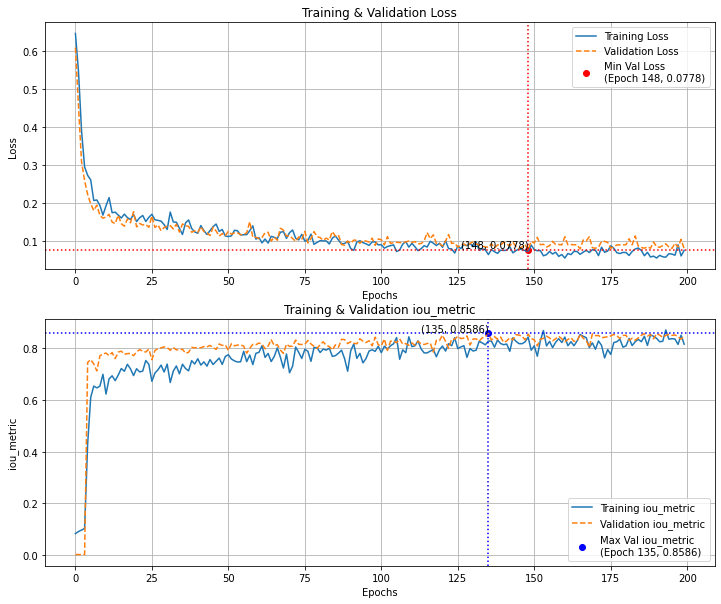

In [31]:
# ✅ 모델 훈련 후 history 객체 확인 필요
history = history  # 모델 훈련 후 다시 할당 필요
loss_name = 'loss'
metric_name = 'iou_metric'
val_loss_name = 'val_' + loss_name
val_metric_name = 'val_' + metric_name

# ✅ 손실 및 정확도 값 가져오기
train_loss = history.history[loss_name]
val_loss = history.history[val_loss_name]
train_acc = history.history[metric_name]
val_acc = history.history[val_metric_name]

# ✅ Validation 기준 최하점 (Loss) & 최고점 (Accuracy) 찾기
min_val_loss_epoch = np.argmin(val_loss)  # 최소 validation loss의 epoch
min_val_loss = val_loss[min_val_loss_epoch]

max_val_acc_epoch = np.argmax(val_acc)  # 최대 validation accuracy의 epoch
max_val_acc = val_acc[max_val_acc_epoch]

# ✅ 손실 (Loss) 그래프
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='dashed')

# 최소 validation loss 지점 표시
plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Min Val Loss\n(Epoch {min_val_loss_epoch}, {min_val_loss:.4f})')
plt.text(min_val_loss_epoch, min_val_loss, f'({min_val_loss_epoch}, {min_val_loss:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 점선 추가 (가로, 세로)
plt.axvline(min_val_loss_epoch, linestyle='dotted', color='red')
plt.axhline(min_val_loss, linestyle='dotted', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# ✅ 정확도 (Accuracy) 그래프
plt.subplot(2, 1, 2)
plt.plot(train_acc, label=('Training ' + metric_name))
plt.plot(val_acc, label=('Validation ' + metric_name), linestyle='dashed')

# 최대 validation accuracy 지점 표시
plt.scatter(max_val_acc_epoch, max_val_acc, color='blue', label=f'Max Val {metric_name}\n(Epoch {max_val_acc_epoch}, {max_val_acc:.4f})')
plt.text(max_val_acc_epoch, max_val_acc, f'({max_val_acc_epoch}, {max_val_acc:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 점선 추가 (가로, 세로)
plt.axvline(max_val_acc_epoch, linestyle='dotted', color='blue')
plt.axhline(max_val_acc, linestyle='dotted', color='blue')

plt.xlabel('Epochs')
plt.ylabel(metric_name)
plt.title(f'Training & Validation {metric_name}')
plt.legend()
plt.grid()

# ✅ 그래프 출력
plt.show()

In [34]:
# callback 설정
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, Callback

# 베스트 모델 저장 (val_loss 기준)
checkpoint_best = ModelCheckpoint(
    filepath="./additional_test/best_model.h5",           # 저장 파일명 (원하는 경로와 파일명으로 변경)
    monitor='val_loss',                 # 모니터링할 metric (예: val_loss)
    save_best_only=True,                # 베스트 모델만 저장
    save_weights_only=True,            # 가중치만 저장
    verbose=1
)

class EpochIntervalCheckpoint(Callback):
    def __init__(self, interval=10):
        super().__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            filepath = (f"./additional_test/{epoch + 201}.h5")
            self.model.save_weights(filepath)
            print(f"\n📦 Saved model's weights at epoch {epoch + 1} to {filepath}")

checkpoint_every_10 = EpochIntervalCheckpoint(
    interval=10
)       

# CSVLogger 콜백: 매 에폭의 loss와 metric을 기록
csv_logger = CSVLogger('./additional_test/training_log.csv', append=True, separator=',')

callbacks = [checkpoint_best, checkpoint_every_10, csv_logger]

# iou metric
def iou_metric(y_true, y_pred):
    """
    y_true: Ground truth (binary mask, 값이 0 또는 1)
    y_pred: 예측 결과 (0~1 범위, sigmoid를 사용한 경우)
    """
    
    # 이미 (batch, height, width) 형태라면, axis=[1,2]로 수정
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2]) - intersection

    iou = tf.reduce_mean((intersection + 1e-10) / (union + 1e-10))
    return iou

In [33]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=21,
    epochs=200,
    callbacks=callbacks
)

Epoch 1/200
21/21 [==============================] - 8s 374ms/step - loss: 0.0628 - iou_metric: 0.8427 - val_loss: 0.0797 - val_iou_metric: 0.8541

Epoch 00001: val_loss improved from inf to 0.07968, saving model to ./additional_test/best_model.h5
Epoch 2/200
21/21 [==============================] - 8s 363ms/step - loss: 0.0653 - iou_metric: 0.8367 - val_loss: 0.0854 - val_iou_metric: 0.8595

Epoch 00002: val_loss did not improve from 0.07968
Epoch 3/200
21/21 [==============================] - 8s 366ms/step - loss: 0.0743 - iou_metric: 0.8269 - val_loss: 0.0865 - val_iou_metric: 0.8515

Epoch 00003: val_loss did not improve from 0.07968
Epoch 4/200
21/21 [==============================] - 8s 366ms/step - loss: 0.0573 - iou_metric: 0.8311 - val_loss: 0.0895 - val_iou_metric: 0.8537

Epoch 00004: val_loss did not improve from 0.07968
Epoch 5/200
21/21 [==============================] - 8s 367ms/step - loss: 0.0550 - iou_metric: 0.8356 - val_loss: 0.0896 - val_iou_metric: 0.8478

Epoch 0

21/21 [==============================] - 8s 380ms/step - loss: 0.0733 - iou_metric: 0.7708 - val_loss: 0.0998 - val_iou_metric: 0.8504

Epoch 00039: val_loss did not improve from 0.07939
Epoch 40/200
21/21 [==============================] - 8s 380ms/step - loss: 0.0556 - iou_metric: 0.8343 - val_loss: 0.0933 - val_iou_metric: 0.8579

Epoch 00040: val_loss did not improve from 0.07939

📦 Saved model's weights at epoch 40 to ./additional_test/240.h5
Epoch 41/200
21/21 [==============================] - 8s 384ms/step - loss: 0.0530 - iou_metric: 0.8479 - val_loss: 0.0817 - val_iou_metric: 0.8601

Epoch 00041: val_loss did not improve from 0.07939
Epoch 42/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0496 - iou_metric: 0.8639 - val_loss: 0.0882 - val_iou_metric: 0.8550

Epoch 00042: val_loss did not improve from 0.07939
Epoch 43/200
21/21 [==============================] - 8s 380ms/step - loss: 0.0513 - iou_metric: 0.8532 - val_loss: 0.1028 - val_iou_metric: 0.8461


21/21 [==============================] - 8s 381ms/step - loss: 0.0587 - iou_metric: 0.8330 - val_loss: 0.1038 - val_iou_metric: 0.8334

Epoch 00117: val_loss did not improve from 0.07565
Epoch 118/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0656 - iou_metric: 0.8295 - val_loss: 0.0899 - val_iou_metric: 0.8580

Epoch 00118: val_loss did not improve from 0.07565
Epoch 119/200
21/21 [==============================] - 8s 382ms/step - loss: 0.0473 - iou_metric: 0.8691 - val_loss: 0.0829 - val_iou_metric: 0.8661

Epoch 00119: val_loss did not improve from 0.07565
Epoch 120/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0544 - iou_metric: 0.8206 - val_loss: 0.0725 - val_iou_metric: 0.8743

Epoch 00120: val_loss improved from 0.07565 to 0.07250, saving model to ./additional_test/best_model.h5

📦 Saved model's weights at epoch 120 to ./additional_test/320.h5
Epoch 121/200
21/21 [==============================] - 8s 380ms/step - loss: 0.0464 - iou_m


Epoch 00195: val_loss did not improve from 0.07250
Epoch 196/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0415 - iou_metric: 0.8895 - val_loss: 0.1013 - val_iou_metric: 0.8666

Epoch 00196: val_loss did not improve from 0.07250
Epoch 197/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0397 - iou_metric: 0.8936 - val_loss: 0.0984 - val_iou_metric: 0.8727

Epoch 00197: val_loss did not improve from 0.07250
Epoch 198/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0508 - iou_metric: 0.8351 - val_loss: 0.0972 - val_iou_metric: 0.8518

Epoch 00198: val_loss did not improve from 0.07250
Epoch 199/200
21/21 [==============================] - 8s 379ms/step - loss: 0.0528 - iou_metric: 0.8593 - val_loss: 0.0888 - val_iou_metric: 0.8700

Epoch 00199: val_loss did not improve from 0.07250
Epoch 200/200
21/21 [==============================] - 8s 381ms/step - loss: 0.0389 - iou_metric: 0.8655 - val_loss: 0.0985 - val_iou_metric: 0.

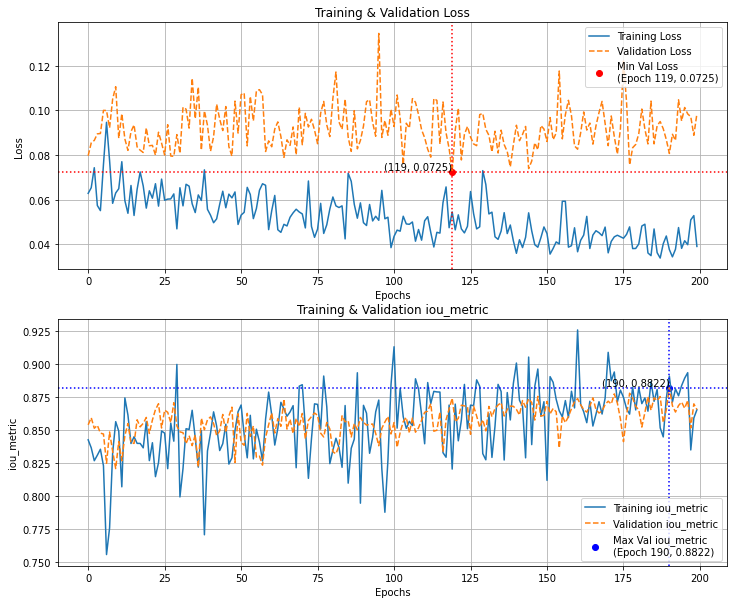

In [34]:
# ✅ 모델 훈련 후 history 객체 확인 필요
history = history  # 모델 훈련 후 다시 할당 필요
loss_name = 'loss'
metric_name = 'iou_metric'
val_loss_name = 'val_' + loss_name
val_metric_name = 'val_' + metric_name

# ✅ 손실 및 정확도 값 가져오기
train_loss = history.history[loss_name]
val_loss = history.history[val_loss_name]
train_acc = history.history[metric_name]
val_acc = history.history[val_metric_name]

# ✅ Validation 기준 최하점 (Loss) & 최고점 (Accuracy) 찾기
min_val_loss_epoch = np.argmin(val_loss)  # 최소 validation loss의 epoch
min_val_loss = val_loss[min_val_loss_epoch]

max_val_acc_epoch = np.argmax(val_acc)  # 최대 validation accuracy의 epoch
max_val_acc = val_acc[max_val_acc_epoch]

# ✅ 손실 (Loss) 그래프
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='dashed')

# 최소 validation loss 지점 표시
plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Min Val Loss\n(Epoch {min_val_loss_epoch}, {min_val_loss:.4f})')
plt.text(min_val_loss_epoch, min_val_loss, f'({min_val_loss_epoch}, {min_val_loss:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 점선 추가 (가로, 세로)
plt.axvline(min_val_loss_epoch, linestyle='dotted', color='red')
plt.axhline(min_val_loss, linestyle='dotted', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# ✅ 정확도 (Accuracy) 그래프
plt.subplot(2, 1, 2)
plt.plot(train_acc, label=('Training ' + metric_name))
plt.plot(val_acc, label=('Validation ' + metric_name), linestyle='dashed')

# 최대 validation accuracy 지점 표시
plt.scatter(max_val_acc_epoch, max_val_acc, color='blue', label=f'Max Val {metric_name}\n(Epoch {max_val_acc_epoch}, {max_val_acc:.4f})')
plt.text(max_val_acc_epoch, max_val_acc, f'({max_val_acc_epoch}, {max_val_acc:.4f})', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# 점선 추가 (가로, 세로)
plt.axvline(max_val_acc_epoch, linestyle='dotted', color='blue')
plt.axhline(max_val_acc, linestyle='dotted', color='blue')

plt.xlabel('Epochs')
plt.ylabel(metric_name)
plt.title(f'Training & Validation {metric_name}')
plt.legend()
plt.grid()

# ✅ 그래프 출력
plt.show()

# Training Log 데이터 확인 및 시각화

In [9]:
import pandas as pd

training_log = pd.read_csv('./additional_test/training_log.csv')
training_log.head()

epoch  iou_metric      loss  val_iou_metric  val_loss
0      0    0.081507  0.646549    9.642165e-15  0.609170
1      1    0.089286  0.546990    9.642165e-15  0.456069
2      2    0.095238  0.390963    9.642165e-15  0.309757
3      3    0.101190  0.295924    9.642165e-15  0.259842
4      4    0.429484  0.273687    7.461584e-01  0.223306

In [10]:
training_log['epoch'] = list(range(1, 401))
training_log.head()

epoch  iou_metric      loss  val_iou_metric  val_loss
0      1    0.081507  0.646549    9.642165e-15  0.609170
1      2    0.089286  0.546990    9.642165e-15  0.456069
2      3    0.095238  0.390963    9.642165e-15  0.309757
3      4    0.101190  0.295924    9.642165e-15  0.259842
4      5    0.429484  0.273687    7.461584e-01  0.223306

In [11]:
epoch_ls = list(training_log['epoch'].values)
# epoch_ls

In [12]:
iou_metric_ls = list(training_log['iou_metric'].values)
loss_ls = list(training_log['loss'].values)
val_iou_metric_ls = list(training_log['val_iou_metric'].values)
val_loss_ls = list(training_log['val_loss'].values)

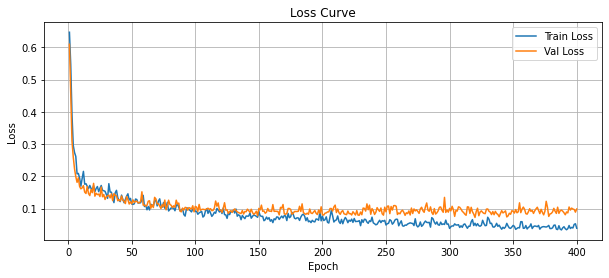

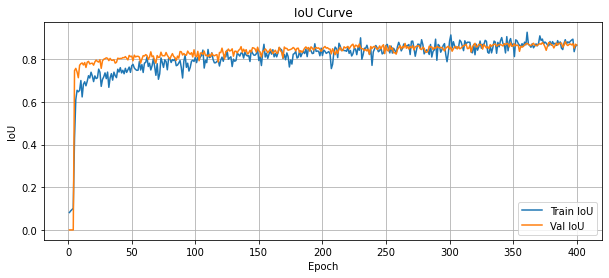

In [61]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(10, 4))
plt.plot(epoch_ls, loss_ls, label='Train Loss')
plt.plot(epoch_ls, val_loss_ls, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# IoU 그래프
plt.figure(figsize=(10, 4))
plt.plot(epoch_ls, iou_metric_ls, label='Train IoU')
plt.plot(epoch_ls, val_iou_metric_ls, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU Curve')
plt.legend()
plt.grid(True)
plt.show()


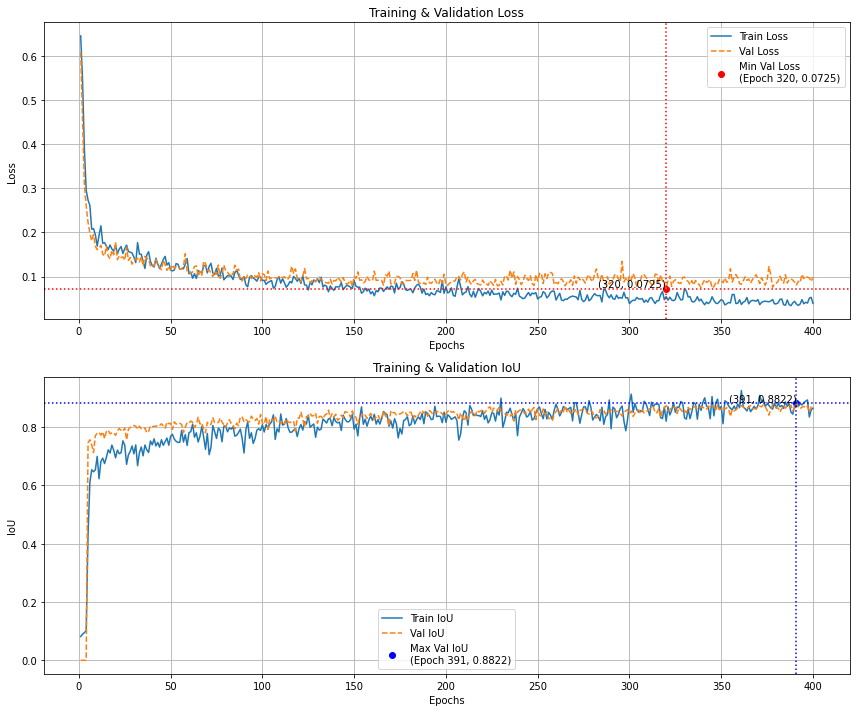

In [63]:
# Validation Loss 최저점
min_val_loss_epoch = np.argmin(val_loss_ls)
min_val_loss = val_loss_ls[min_val_loss_epoch]

# Validation IoU 최고점
max_val_iou_epoch = np.argmax(val_iou_metric_ls)
max_val_iou = val_iou_metric_ls[max_val_iou_epoch]

# ---------- 그래프 ----------
plt.figure(figsize=(12, 10))

# 🔻 Loss 그래프
plt.subplot(2, 1, 1)
plt.plot(epoch_ls, loss_ls, label='Train Loss')
plt.plot(epoch_ls, val_loss_ls, label='Val Loss', linestyle='dashed')

# 최소 val_loss 지점 표시
plt.scatter(epoch_ls[min_val_loss_epoch], min_val_loss, color='red',
            label=f'Min Val Loss\n(Epoch {epoch_ls[min_val_loss_epoch]}, {min_val_loss:.4f})')
plt.axvline(epoch_ls[min_val_loss_epoch], linestyle='dotted', color='red')
plt.axhline(min_val_loss, linestyle='dotted', color='red')
plt.text(epoch_ls[min_val_loss_epoch], min_val_loss,
         f'({epoch_ls[min_val_loss_epoch]}, {min_val_loss:.4f})',
         fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# 🔺 IoU 그래프
plt.subplot(2, 1, 2)
plt.plot(epoch_ls, iou_metric_ls, label='Train IoU')
plt.plot(epoch_ls, val_iou_metric_ls, label='Val IoU', linestyle='dashed')

# 최대 val_iou 지점 표시
plt.scatter(epoch_ls[max_val_iou_epoch], max_val_iou, color='blue',
            label=f'Max Val IoU\n(Epoch {epoch_ls[max_val_iou_epoch]}, {max_val_iou:.4f})')
plt.axvline(epoch_ls[max_val_iou_epoch], linestyle='dotted', color='blue')
plt.axhline(max_val_iou, linestyle='dotted', color='blue')
plt.text(epoch_ls[max_val_iou_epoch], max_val_iou,
         f'({epoch_ls[max_val_iou_epoch]}, {max_val_iou:.4f})',
         fontsize=10, verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training & Validation IoU')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, n=5):
    data = np.array(data)
    if n < 1:
        raise ValueError("n must be >= 1")
    return np.convolve(data, np.ones(n)/n, mode='valid')

def plot_training_curves_with_smoothing(n=5):
    """
    이동 평균선(MA n포인트) 포함한 학습 곡선 그래프 + 최고/최저점 표시
    """

    # 이동평균 계산
    loss_smooth = moving_average(loss_ls, n)
    val_loss_smooth = moving_average(val_loss_ls, n)
    iou_smooth = moving_average(iou_metric_ls, n)
    val_iou_smooth = moving_average(val_iou_metric_ls, n)

    # 이동평균 기준 에포크 계산 (n-1 이후부터 시작)
    smooth_epoch = epoch_ls[n-1:]

    # ✅ 최저 val_loss 지점
    min_val_loss_idx = np.argmin(val_loss_smooth)
    min_val_loss = val_loss_smooth[min_val_loss_idx]
    min_val_loss_epoch = smooth_epoch[min_val_loss_idx]

    # ✅ 최고 val_iou_metric 지점
    max_val_iou_idx = np.argmax(val_iou_smooth)
    max_val_iou = val_iou_smooth[max_val_iou_idx]
    max_val_iou_epoch = smooth_epoch[max_val_iou_idx]

    # ---------- 그래프 ----------
    plt.figure(figsize=(12, 10))

    # 🔻 Loss 그래프
    plt.subplot(2, 1, 1)
#     plt.plot(epoch_ls, loss_ls, label='Train Loss', alpha=0.3)
#     plt.plot(epoch_ls, val_loss_ls, label='Val Loss', alpha=0.3, linestyle='dashed')
    plt.plot(smooth_epoch, loss_smooth, label=f'Train Loss (MA{n})', color='orange')
    plt.plot(smooth_epoch, val_loss_smooth, label=f'Val Loss (MA{n})', color='red', linestyle='dashed')

    # 🔴 최저점 표시
    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Min Smoothed Val Loss\n(Epoch {min_val_loss_epoch}, {min_val_loss:.4f})')
    plt.axvline(min_val_loss_epoch, linestyle='dotted', color='red')
    plt.axhline(min_val_loss, linestyle='dotted', color='red')
    plt.text(min_val_loss_epoch, min_val_loss,
             f'({min_val_loss_epoch}, {min_val_loss:.4f})',
             fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss with Moving Average (n={n})')
    plt.legend()
    plt.grid()

    # 🔺 IoU 그래프
    plt.subplot(2, 1, 2)
#     plt.plot(epoch_ls, iou_metric_ls, label='Train IoU', alpha=0.3)
#     plt.plot(epoch_ls, val_iou_metric_ls, label='Val IoU', alpha=0.3, linestyle='dashed')
    plt.plot(smooth_epoch, iou_smooth, label=f'Train IoU (MA{n})', color='green')
    plt.plot(smooth_epoch, val_iou_smooth, label=f'Val IoU (MA{n})', color='blue', linestyle='dashed')

    # 🔵 최고점 표시
    plt.scatter(max_val_iou_epoch, max_val_iou, color='blue', label=f'Max Smoothed Val IoU\n(Epoch {max_val_iou_epoch}, {max_val_iou:.4f})')
    plt.axvline(max_val_iou_epoch, linestyle='dotted', color='blue')
    plt.axhline(max_val_iou, linestyle='dotted', color='blue')
    plt.text(max_val_iou_epoch, max_val_iou,
             f'({max_val_iou_epoch}, {max_val_iou:.4f})',
             fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title(f'IoU with Moving Average (n={n})')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


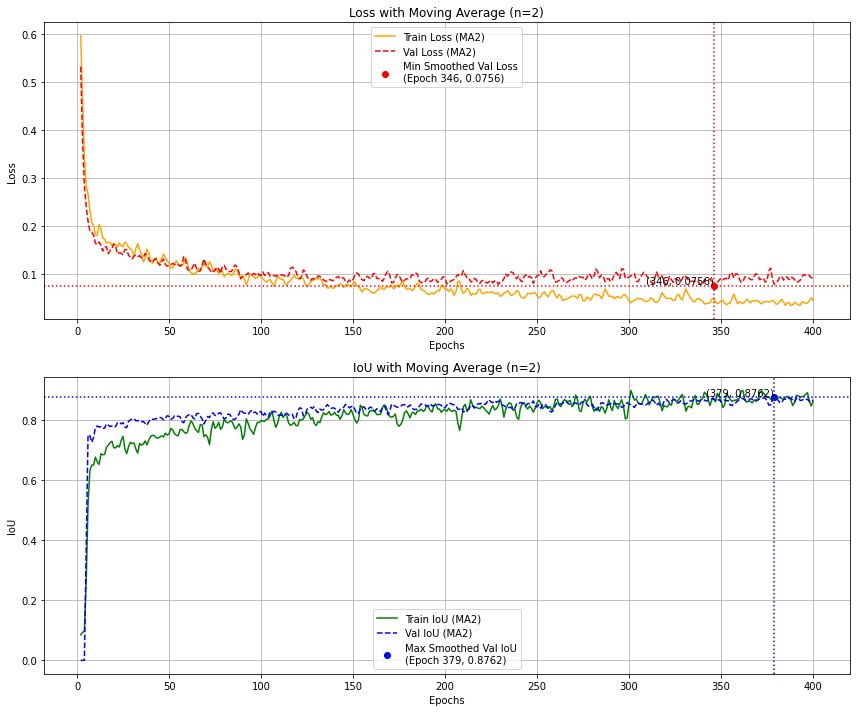

In [73]:
plot_training_curves_with_smoothing(n=2)

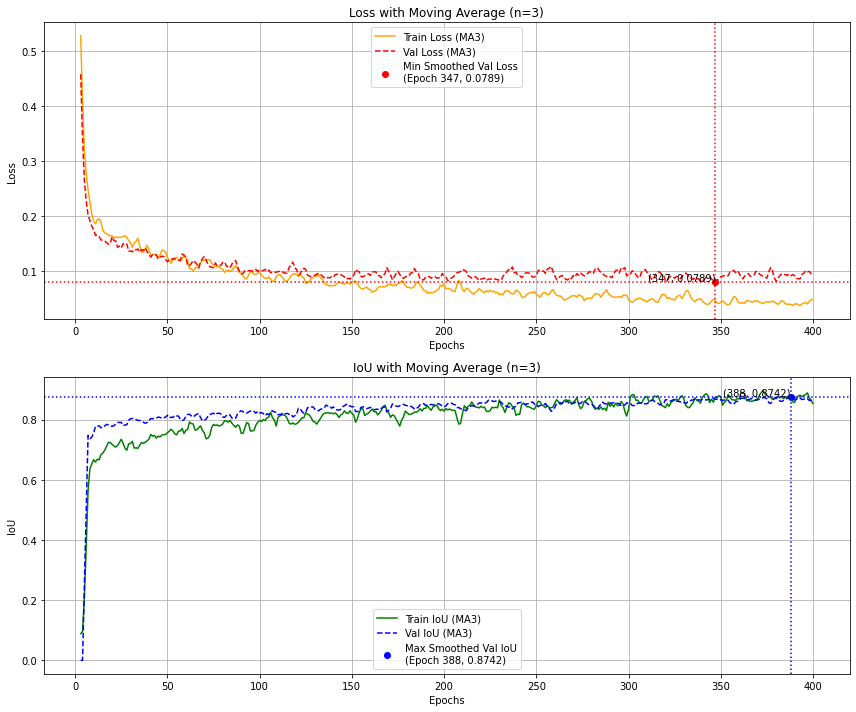

In [74]:
plot_training_curves_with_smoothing(n=3)

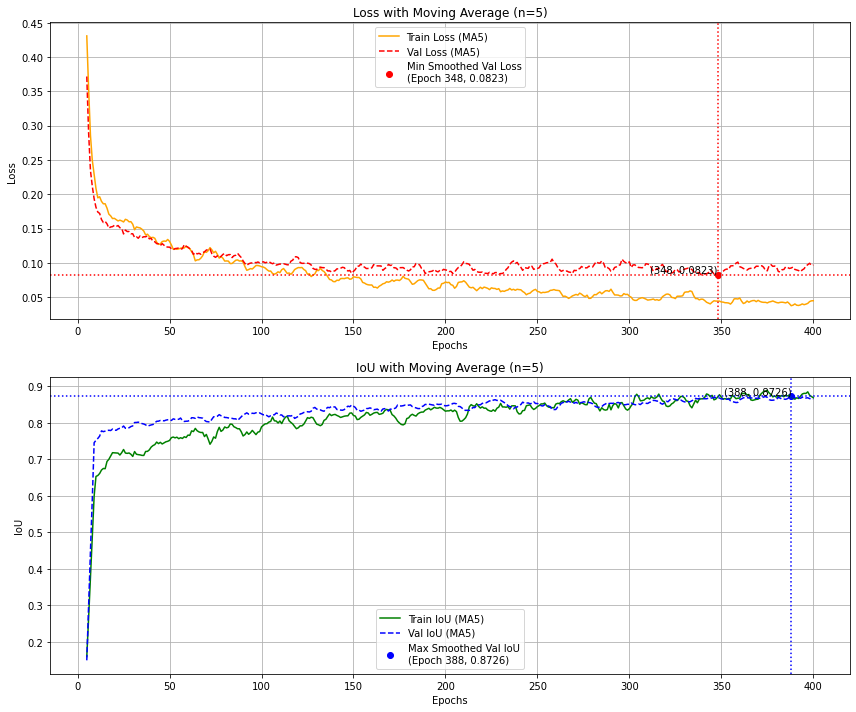

In [75]:
plot_training_curves_with_smoothing(n=5)

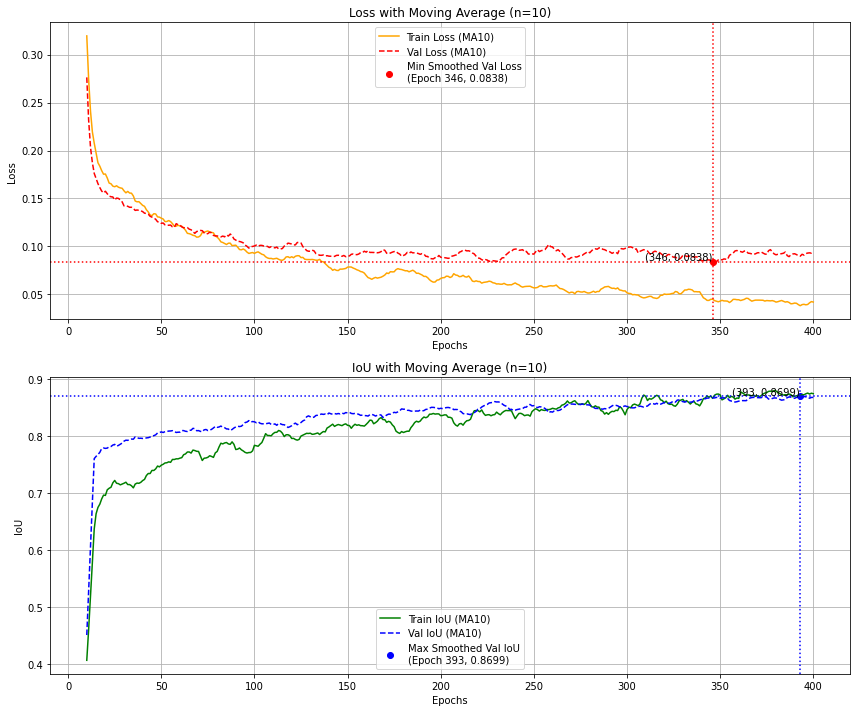

In [76]:
plot_training_curves_with_smoothing(n=10)

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, n=5):
    data = np.array(data)
    if n < 1:
        raise ValueError("n must be >= 1")
    return np.convolve(data, np.ones(n)/n, mode='valid')

def plot_training_curves_with_smoothing(n=5, epoch_start=0, epoch_end=None):
    """
    이동평균 포함 학습 곡선 그래프 + 선택된 범위 내에서 최고/최저점 표시

    Args:
        n (int): 이동 평균 윈도우 크기
        epoch_start (int): 그래프 시작 에포크 (0부터 시작)
        epoch_end (int): 그래프 끝 에포크 (None이면 전체)
    """

    # 전체 epoch 리스트 기준
    total_epochs = len(epoch_ls)
    if epoch_end is None:
        epoch_end = total_epochs

    # 슬라이싱 범위 지정
    range_slice = slice(epoch_start, epoch_end)

    # 기준 범위 내 데이터 자르기
    epoch_range = epoch_ls[range_slice]
    loss_range = loss_ls[range_slice]
    val_loss_range = val_loss_ls[range_slice]
    iou_range = iou_metric_ls[range_slice]
    val_iou_range = val_iou_metric_ls[range_slice]

    # 이동평균 계산 (해당 범위만)
    loss_smooth = moving_average(loss_range, n)
    val_loss_smooth = moving_average(val_loss_range, n)
    iou_smooth = moving_average(iou_range, n)
    val_iou_smooth = moving_average(val_iou_range, n)

    # 이동평균 결과에 맞춰 에포크 조정
    smooth_epoch = epoch_range[n-1:]

    # 최저/최고 계산 (이동평균 결과 기준)
    min_val_loss_idx = np.argmin(val_loss_smooth)
    min_val_loss = val_loss_smooth[min_val_loss_idx]
    min_val_loss_epoch = smooth_epoch[min_val_loss_idx]

    max_val_iou_idx = np.argmax(val_iou_smooth)
    max_val_iou = val_iou_smooth[max_val_iou_idx]
    max_val_iou_epoch = smooth_epoch[max_val_iou_idx]

    # ---------- 그래프 ----------
    plt.figure(figsize=(12, 10))

    # 🔻 Loss 그래프
    plt.subplot(2, 1, 1)
#     plt.plot(epoch_range, loss_range, label='Train Loss', alpha=0.3)
#     plt.plot(epoch_range, val_loss_range, label='Val Loss', alpha=0.3, linestyle='dashed')
    plt.plot(smooth_epoch, loss_smooth, label=f'Train Loss (MA{n})', color='orange')
    plt.plot(smooth_epoch, val_loss_smooth, label=f'Val Loss (MA{n})', color='red', linestyle='dashed')

    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Min Smoothed Val Loss\n(Epoch {min_val_loss_epoch}, {min_val_loss:.4f})')
    plt.axvline(min_val_loss_epoch, linestyle='dotted', color='red')
    plt.axhline(min_val_loss, linestyle='dotted', color='red')
    plt.text(min_val_loss_epoch, min_val_loss,
             f'({min_val_loss_epoch}, {min_val_loss:.4f})',
             fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss with Moving Average (n={n})')
    plt.legend()
    plt.grid()

    # 🔺 IoU 그래프
    plt.subplot(2, 1, 2)
#     plt.plot(epoch_range, iou_range, label='Train IoU', alpha=0.3)
#     plt.plot(epoch_range, val_iou_range, label='Val IoU', alpha=0.3, linestyle='dashed')
    plt.plot(smooth_epoch, iou_smooth, label=f'Train IoU (MA{n})', color='green')
    plt.plot(smooth_epoch, val_iou_smooth, label=f'Val IoU (MA{n})', color='blue', linestyle='dashed')

    plt.scatter(max_val_iou_epoch, max_val_iou, color='blue', label=f'Max Smoothed Val IoU\n(Epoch {max_val_iou_epoch}, {max_val_iou:.4f})')
    plt.axvline(max_val_iou_epoch, linestyle='dotted', color='blue')
    plt.axhline(max_val_iou, linestyle='dotted', color='blue')
    plt.text(max_val_iou_epoch, max_val_iou,
             f'({max_val_iou_epoch}, {max_val_iou:.4f})',
             fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title(f'IoU with Moving Average (n={n})')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

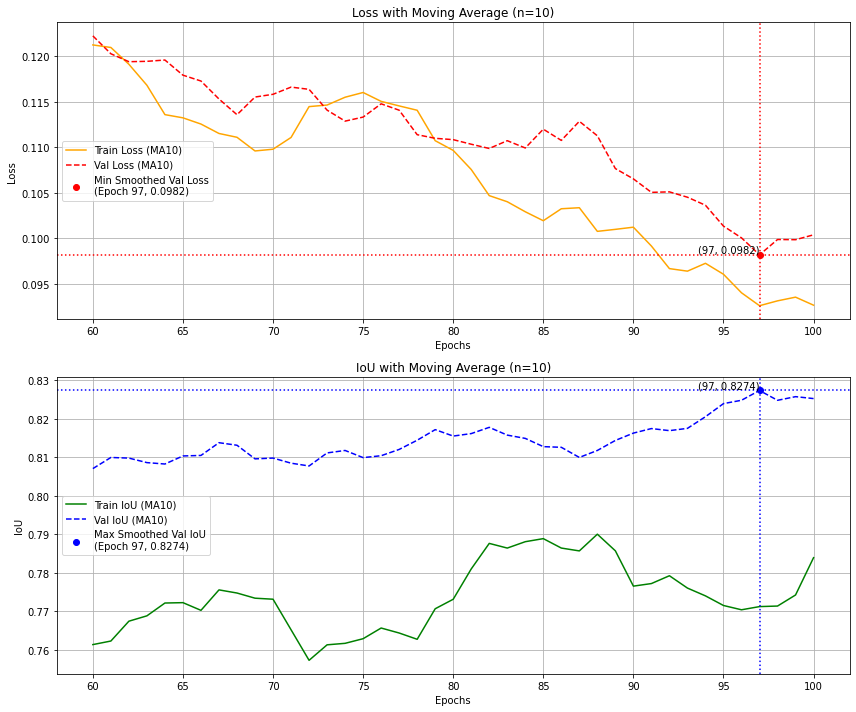

In [82]:
plot_training_curves_with_smoothing(n=10, epoch_start=50, epoch_end=100)

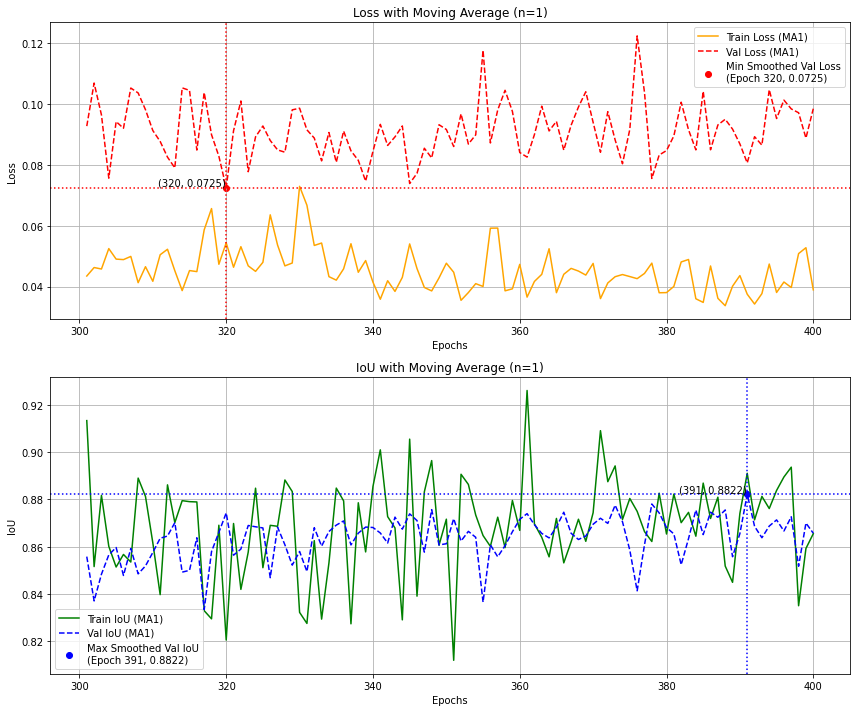

In [83]:
plot_training_curves_with_smoothing(n=1, epoch_start=300, epoch_end=400)

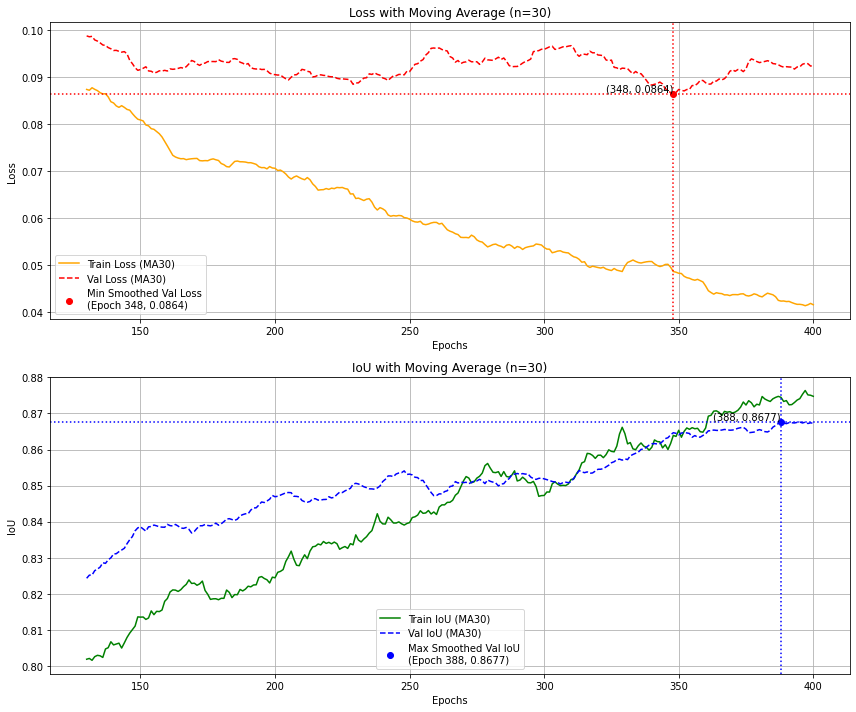

In [91]:
plot_training_curves_with_smoothing(n=30, epoch_start=100, epoch_end=400)

### 일반화 성능이 가장 높을 것 같은 Epoch(가중치)
1. Epoch 80 : train loss와 val loss가 분리되는 지점이다.
2. Epoch 320 : val_loss 최저점
3. Epoch 390 : val_iou 최고점
4. Epoch 350 : n=30 일때, val_loss 최저점
5. Epoch 200 : 80과 320 중간 값

# 정량 평가

In [13]:
# iou 계산
def calculate_iou(y_true, y_pred):
    """
    IoU 계산 함수 - 3채널 입력 지원
    y_true: (batch, height, width, channels) - binary mask (0 또는 1)
    y_pred: (batch, height, width, channels) - 예측 결과 (0~1), sigmoid 후 값
    """
    # 예측 결과 이진화
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # axis = [1, 2, 3] → (height, width, channel) 기준으로 합산
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    iou = tf.reduce_mean((intersection + 1e-10) / (union + 1e-10))  # batch 단위 평균
    return iou

In [14]:
# test_generator에서 전체 데이터 추출
all_inputs = []
all_outputs = []

for i in range(len(test_generator)):
    batch_inputs, batch_outputs = test_generator[i]
    all_inputs.append(batch_inputs)
    all_outputs.append(batch_outputs)

# 리스트를 NumPy 배열로 변환
inputs = np.concatenate(all_inputs, axis=0)
outputs = np.concatenate(all_outputs, axis=0)

print("inputs shape:", inputs.shape)
print("outputs shape:", outputs.shape)


inputs shape: (16, 224, 224, 3)
outputs shape: (16, 224, 224)


In [15]:
model = build_model()
model.load_weights('./additional_test/80.h5')

In [16]:
predict = model(np.expand_dims(inputs[0], axis=0))
predict

<tf.Tensor: shape=(1, 224, 224, 1), dtype=float32, numpy=
array([[[[6.28166646e-03],
         [2.29054340e-03],
         [1.41858158e-03],
         ...,
         [1.15086463e-04],
         [2.65937007e-04],
         [5.89482079e-04]],

        [[1.85118217e-04],
         [2.15983255e-05],
         [1.08364447e-05],
         ...,
         [1.73430990e-07],
         [3.96066611e-07],
         [2.98959299e-06]],

        [[5.93917957e-06],
         [3.21073856e-07],
         [1.36466156e-07],
         ...,
         [3.50065948e-10],
         [2.38117726e-09],
         [3.62895207e-08]],

        ...,

        [[1.63030609e-01],
         [1.18818544e-01],
         [1.16399445e-01],
         ...,
         [1.13560855e-02],
         [2.20956001e-02],
         [4.17377353e-02]],

        [[2.16663823e-01],
         [1.86482504e-01],
         [1.80251554e-01],
         ...,
         [3.37305553e-02],
         [5.40924855e-02],
         [1.01562880e-01]],

        [[3.27123582e-01],
         [2

In [17]:
predict = tf.squeeze(predict)
predict.shape

TensorShape([224, 224])

In [18]:
np.expand_dims(predict, axis=0).shape

(1, 224, 224)

In [19]:
np.expand_dims(outputs[0], axis=0).shape

(1, 224, 224)

In [20]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # ← 추가
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection

    iou = tf.reduce_mean((intersection + 1e-10) / (union + 1e-10))
    return iou

In [21]:
iou_metric(np.expand_dims(outputs[0], axis=0), np.expand_dims(predict, axis=0)).numpy()

0.84480494

In [22]:
weights_ls = ['./additional_test/80.h5', './additional_test/200.h5', './additional_test/320.h5', './additional_test/350.h5', './additional_test/390.h5']

iou_dict = dict()
for weights in weights_ls:
    model.load_weights(weights)
    
    iou_ls = list()
    for input, output in zip(inputs, outputs):
        predict = model(np.expand_dims(input, axis=0))
        predict = tf.squeeze(predict)
        predict = np.expand_dims(predict, axis=0)
        
        output = np.expand_dims(output, axis=0)
        iou = iou_metric(output, predict).numpy()
        
        iou_ls.append(iou)
    
    iou_dict[weights] = iou_ls
        

In [48]:
iou_dict[weights_ls[0]]

[0.84480494,
 0.88475037,
 0.9093614,
 0.80106604,
 0.852537,
 0.89143497,
 0.92472845,
 0.26236248,
 0.8132907,
 0.94612795,
 0.8149656,
 0.86092585,
 0.59929186,
 0.730286,
 0.8699932,
 0.7958077]

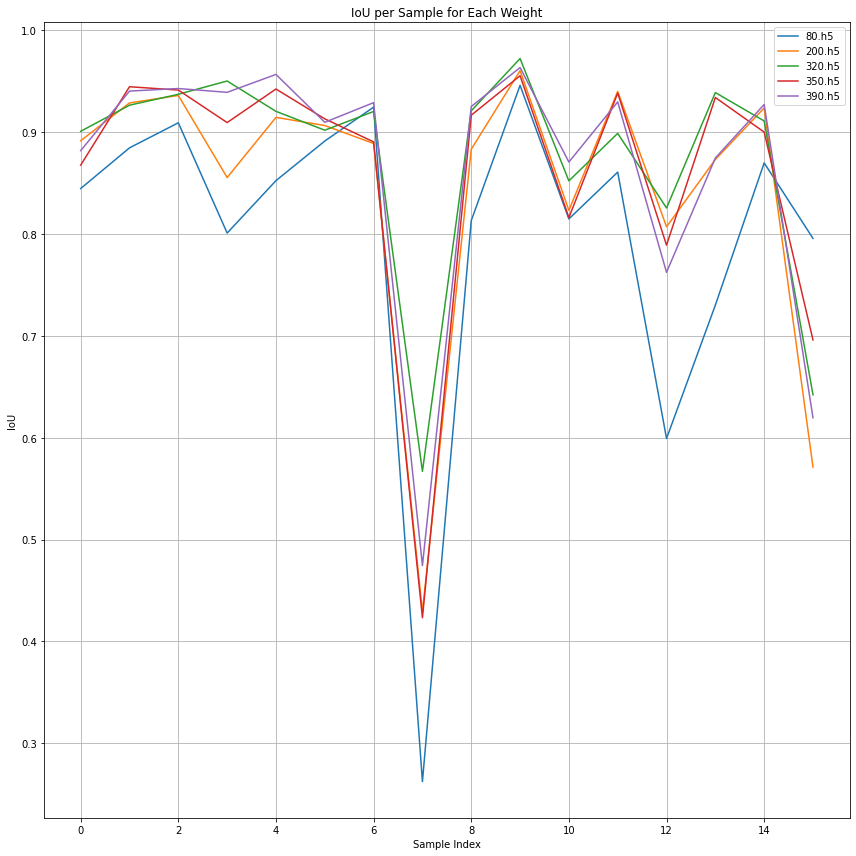

In [50]:
plt.figure(figsize=(12, 12))

# 샘플 개수만큼 index 생성
sample_indices = list(range(len(next(iter(iou_dict.values())))))

# 각 weight에 대해 IoU list plot
for weight_path, iou_values in iou_dict.items():
    plt.plot(sample_indices, iou_values, label=weight_path.split('/')[-1])  # 파일명만 label로

plt.xlabel("Sample Index")
plt.ylabel("IoU")
plt.title("IoU per Sample for Each Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# 평균 IoU 저장할 딕셔너리
mean_iou_dict = dict()

for weights, iou_list in iou_dict.items():
    mean_iou = np.mean(iou_list)
    mean_iou_dict[weights] = mean_iou

# 출력 예시
for weights, mean_iou in mean_iou_dict.items():
    print(f"{weights} -> Mean IoU: {mean_iou:.4f}")

./additional_test/80.h5 -> Mean IoU: 0.8001
./additional_test/200.h5 -> Mean IoU: 0.8459
./additional_test/320.h5 -> Mean IoU: 0.8743
./additional_test/350.h5 -> Mean IoU: 0.8613
./additional_test/390.h5 -> Mean IoU: 0.8656


# 정성 평가

In [51]:
predict = model(np.expand_dims(input, axis=0))
predict = tf.squeeze(predict)
predict = np.expand_dims(predict, axis=0)

output = np.expand_dims(output, axis=0)

In [54]:
input.shape

(224, 224, 3)

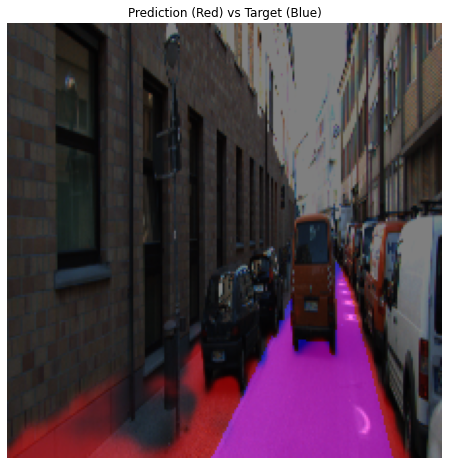

In [55]:
predict = tf.squeeze(predict)
output = tf.squeeze(output)

resized = input
overlay = np.zeros_like(resized, dtype=np.float32)

# 예측 영역 (빨간색)
overlay[..., 0] = predict * 1.0  # Red 채널 활성화 (1이면 빨간색)

# 실제 영역 (파란색)
overlay[..., 2] = output * 1.0  # Blue 채널 활성화 (1이면 파란색)

# 겹치는 영역 (빨간 + 파랑 = 보라색)
# 이미 겹치는 부분은 색이 섞이므로 따로 추가할 필요 없음

# 3. 투명도 적용 (alpha blending)
alpha = 0.5
blended_img = (1 - alpha) * resized + alpha * overlay

# 4. 결과 시각화
plt.figure(figsize=(8, 8))
plt.imshow(blended_img)
plt.axis("off")
plt.title("Prediction (Red) vs Target (Blue)")
plt.show()

In [56]:
def visualize_prediction(input_img, output_mask, pred_mask, alpha=0.5, figsize=(8, 8), title="Prediction (Red) vs Target (Blue)"):
    """
    입력 이미지(input_img), 실제 마스크(output_mask), 예측 마스크(pred_mask)를 받아서
    오버레이 시각화를 수행합니다.
    
    Parameters:
        input_img (np.array): 원본 이미지 (H, W, 3)
        output_mask (np.array or tensor): 실제 정답 마스크 (H, W)
        pred_mask (np.array or tensor): 모델의 예측 마스크 (H, W)
        alpha (float): 오버레이할 때의 투명도
        figsize (tuple): 출력 이미지 크기
        title (str): 그래프 제목
    """
    # 마스크가 텐서이면 numpy로 변환
    if isinstance(output_mask, tf.Tensor):
        output_mask = output_mask.numpy()
    if isinstance(pred_mask, tf.Tensor):
        pred_mask = pred_mask.numpy()

    # 채널 차원 제거
    pred_mask = np.squeeze(pred_mask)
    output_mask = np.squeeze(output_mask)

    # 오버레이 생성
    overlay = np.zeros_like(input_img, dtype=np.float32)
    overlay[..., 0] = pred_mask * 1.0  # Red for prediction
    overlay[..., 2] = output_mask * 1.0  # Blue for ground truth

    # 블렌딩
    blended = (1 - alpha) * input_img + alpha * overlay

    # 시각화
    plt.figure(figsize=figsize)
    plt.imshow(blended)
    plt.axis("off")
    plt.title(title)
    plt.show()


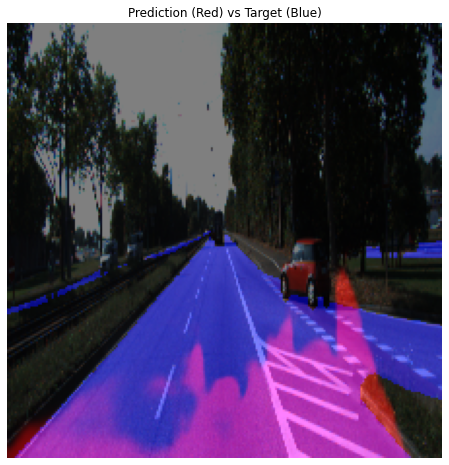

In [57]:
visualize_prediction(inputs[0], outputs[0], predict)

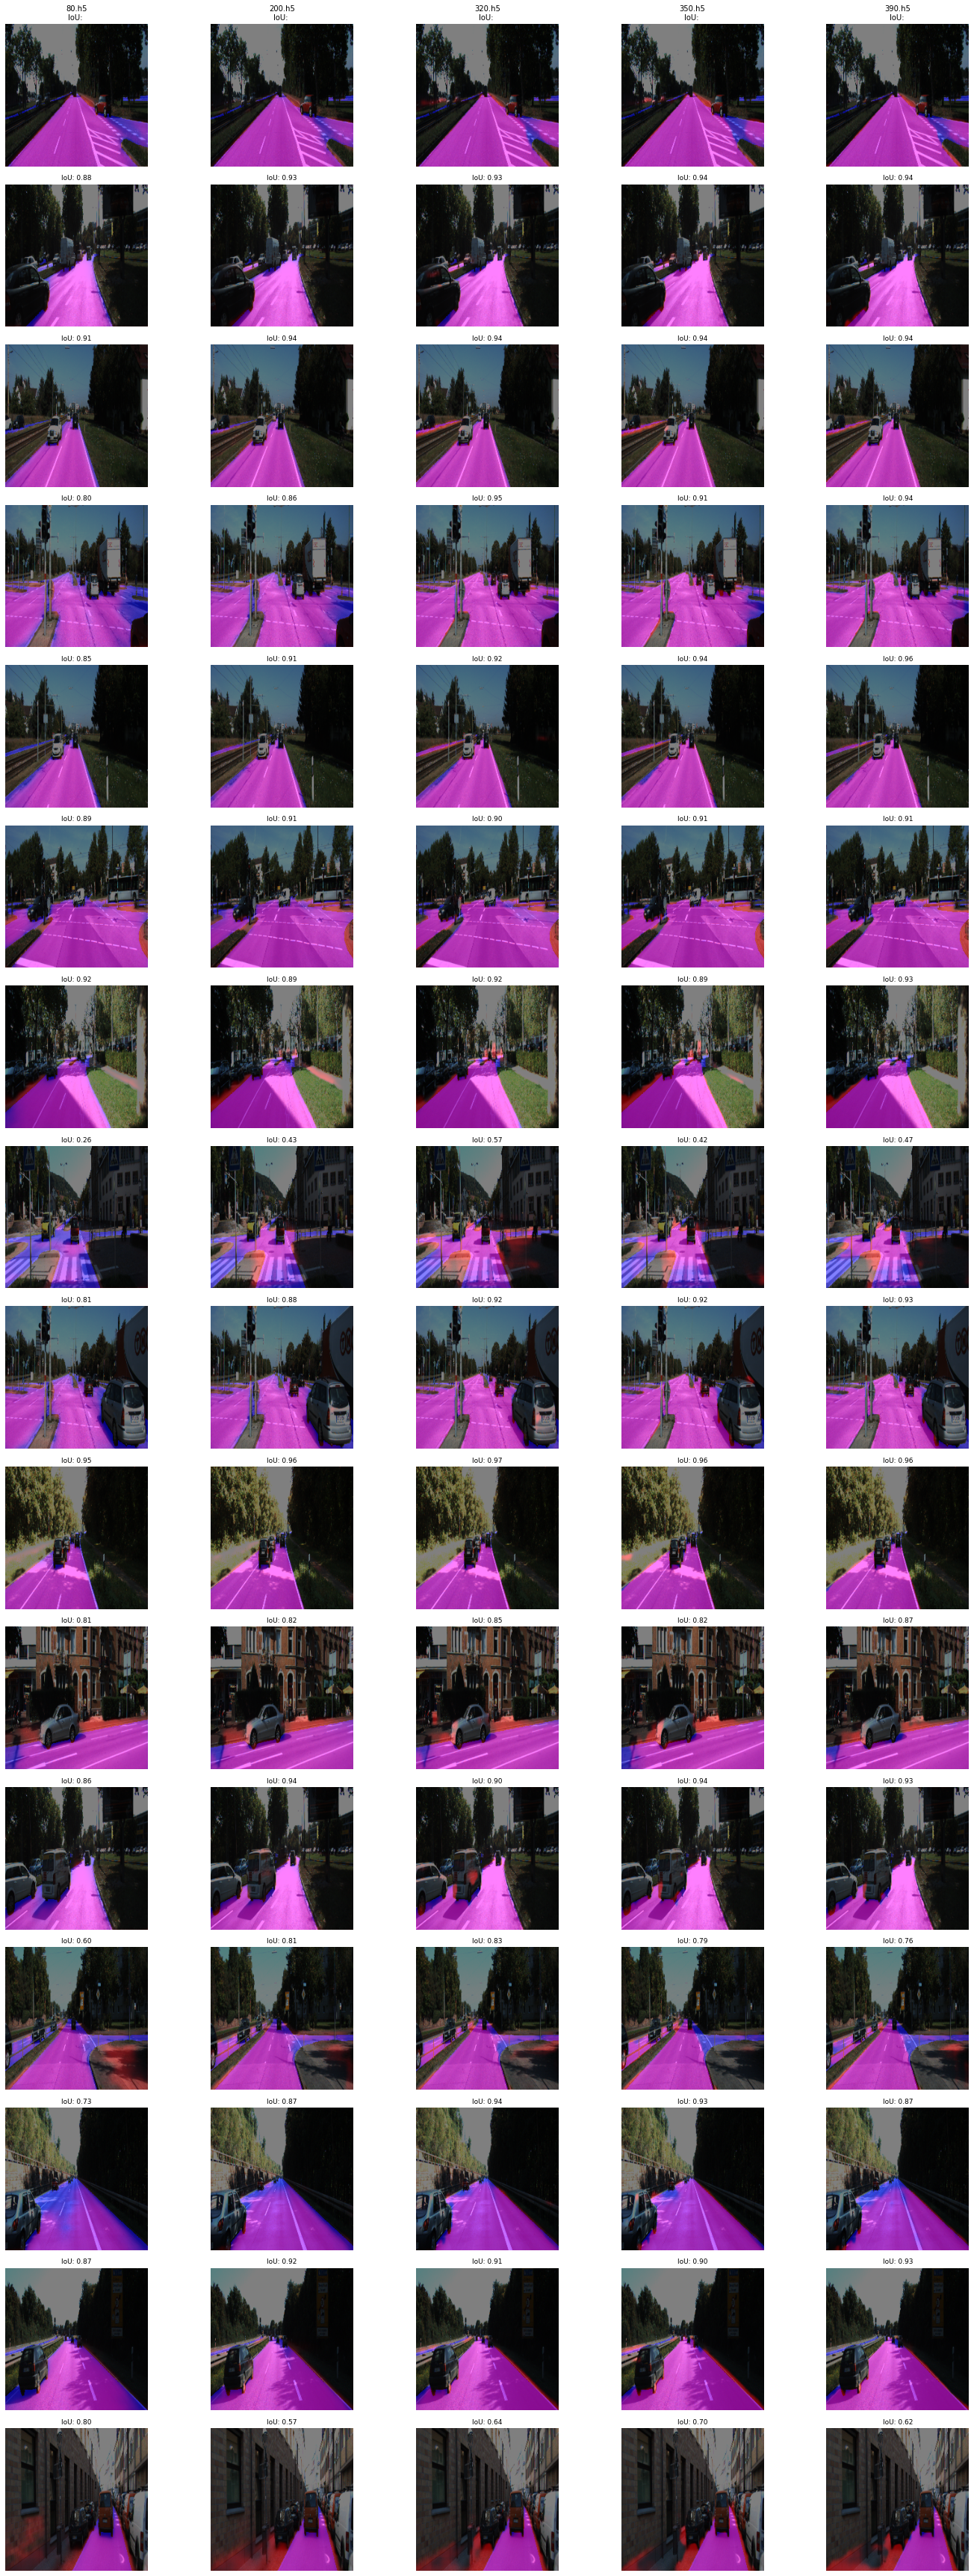

In [59]:
# 16 samples × 5 weights
num_samples = len(inputs)          # =16
num_weights = len(weights_ls)      # =5

fig, axes = plt.subplots(num_samples, num_weights, figsize=(num_weights * 4, num_samples * 3))

for col, weights in enumerate(weights_ls):
    model.load_weights(weights)

    for row in range(num_samples):
        input_img = inputs[row]
        target_mask = outputs[row]

        # 예측
        predict = model(np.expand_dims(input_img, axis=0))
        predict = tf.squeeze(predict)

        # IoU 계산
        iou = iou_metric(np.expand_dims(target_mask, axis=0), np.expand_dims(predict, axis=0)).numpy()

        # 시각화 이미지 생성 (blend)
        pred_mask = np.squeeze(predict)
        overlay = np.zeros_like(input_img, dtype=np.float32)
        overlay[..., 0] = pred_mask * 1.0  # Red
        overlay[..., 2] = target_mask * 1.0  # Blue
        blended = (1 - 0.5) * input_img + 0.5 * overlay

        # 해당 위치 subplot에 이미지 출력
        ax = axes[row, col]
        ax.imshow(blended)
        ax.axis("off")
        ax.set_title(f"IoU: {iou:.2f}", fontsize=9)

        # 첫 열이라면 row index 표시
        if col == 0:
            ax.set_ylabel(f"Sample {row}", fontsize=9)

# 상단에 weight 파일명 표시
for col, weights in enumerate(weights_ls):
    axes[0, col].set_title(f"{weights.split('/')[-1]}\nIoU: ", fontsize=10)

plt.tight_layout()
plt.show()


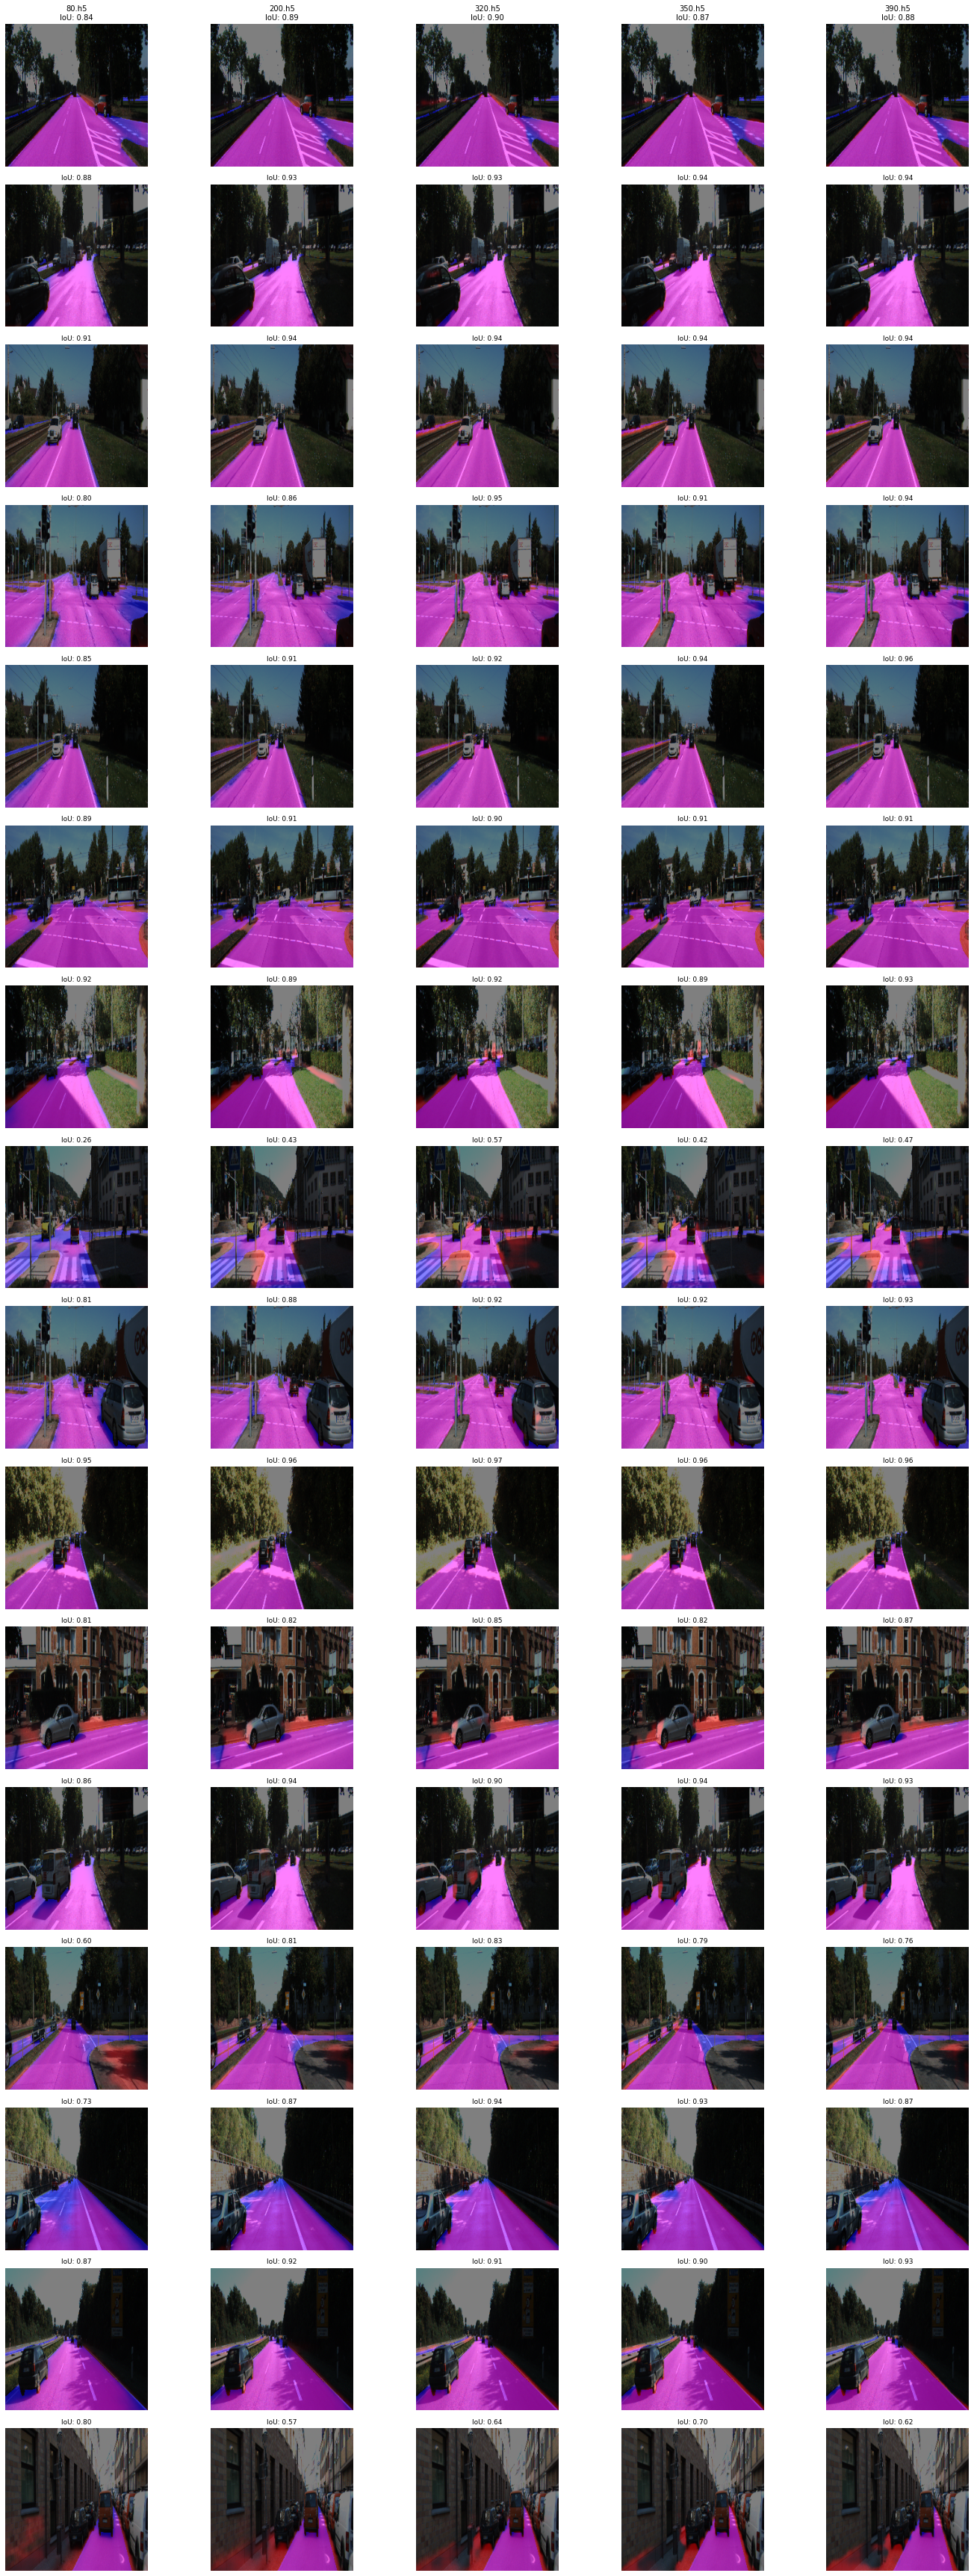

In [60]:
import matplotlib.pyplot as plt

num_samples = len(inputs)          # =16
num_weights = len(weights_ls)      # =5

fig, axes = plt.subplots(num_samples, num_weights, figsize=(num_weights * 4, num_samples * 3))

for col, weights in enumerate(weights_ls):
    model.load_weights(weights)

    for row in range(num_samples):
        input_img = inputs[row]
        target_mask = outputs[row]

        # 예측
        predict = model(np.expand_dims(input_img, axis=0))
        predict = tf.squeeze(predict)

        # IoU 계산
        iou = iou_metric(np.expand_dims(target_mask, axis=0), np.expand_dims(predict, axis=0)).numpy()

        # 시각화 이미지 생성 (blend)
        pred_mask = np.squeeze(predict)
        overlay = np.zeros_like(input_img, dtype=np.float32)
        overlay[..., 0] = pred_mask * 1.0  # Red
        overlay[..., 2] = target_mask * 1.0  # Blue
        blended = (1 - 0.5) * input_img + 0.5 * overlay

        ax = axes[row, col]
        ax.imshow(blended)
        ax.axis("off")

        # 타이틀 - 첫 번째 행에는 weight 이름 + IoU, 나머지 행은 IoU만
        if row == 0:
            weight_name = weights.split("/")[-1]
            ax.set_title(f"{weight_name}\nIoU: {iou:.2f}", fontsize=10)
        else:
            ax.set_title(f"IoU: {iou:.2f}", fontsize=9)

        # 첫 번째 열에는 샘플 번호 추가
        if col == 0:
            ax.set_ylabel(f"Sample {row}", fontsize=9)

plt.tight_layout()
plt.show()
